## Luca Massaron: Model for Behavioural Cloning based on the paper "End to End Learning for Self-Driving Cars" by NVIDIA engineers.

In [1]:
import numpy as np
import pandas as pd
import json
import re
import os
from scipy import ndimage, misc
from scipy import signal

import cv2
from PIL import Image
from PIL import ImageOps

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop, adagrad
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.set_image_dim_ordering('tf')

In [3]:
def driving_acc(y_true, y_pred, threshold = 0.5/25.):
    """
    Shows what percentage of the batch results are within 0.5 deg of true data
    Author: Thomas Antony
    """
    
    diff = K.abs(y_true - y_pred)
    good_rows = K.lesser(diff, threshold)
    good = K.sum(K.cast(good_rows, K.floatx()))
    total = K.sum(K.ones_like(y_true))
    return good*100/total

In [4]:
def ETE(weights_path=None, color_type_global=3, img_rows=100, img_cols=200):
    """
    Keras' neural architecture mimicking the solution illustrated in the paper "End to End Learning for Self Driving Cars"
    """
    # Size of filters
    nb_filters = 24
    nb_filters = 36
    nb_filters = 48
    nb_filters = 64
    # size of pooling area for max pooling
    pool_size = (3, 3)
    # convolution kernel size
    input_shape = (img_rows,img_cols,color_type_global)

    model = Sequential()
    # First normalization layer
    model.add(BatchNormalization(axis=1, input_shape=input_shape))
    
    # Convolutional layers made of 5 convolutions, a maxpooling and a dropout
    # Each layer has ReLu activations and Batchnormalization
    model.add(Convolution2D(3, 5, 5,border_mode='valid', subsample=(2, 2)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(2, 2)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample=(2, 2)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Convolution2D(48, 3, 3, border_mode='valid', subsample=(1, 1)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(1, 1)))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.2))
    
    # Flattening of the neurons, first hidden layer with ReLu activation, batchnormalization and dropout
    model.add(Flatten())
    model.add(Dense(150, init='normal')) # W_constraint=maxnorm(3)
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    
    # Second hidden layer with ReLu activation, batchnormalization and dropout
    model.add(Dense(50, init='normal'))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    
    # Third hidden layer with ReLu activation, batchnormalization and dropout
    model.add(Dense(10, init='normal'))
    model.add(BatchNormalization(axis=1))
    model.add(Activation('linear'))
    
    # Output neuron
    model.add(Dense(1, name="output"))

    if weights_path:
        # If necessary I can load any pre-computed weights
        model.load_weights(weights_path)

    print(model.summary())

    # Optimization is SDG, with high learning rate (allowed by batchnormalization)
    # The parameters have been set inspired by the paper:
    # "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"
    
    optim = SGD(lr=0.1, decay=1e-8, momentum=0.9, nesterov=True)
    #optim = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    # Since it is a regression problem the 
    model.compile(optimizer = optim,
                  loss = 'mean_squared_error',
                  metrics=[driving_acc])
    return model

In [5]:
# The input shape of the images is defined and feed into the model which is compiled
# Please notice that we are working with Theano, so the color channels are put before the width and height
# This implies that we have to modify any image feed into the net accordingly to this schema
color_type_global = 3
img_rows, img_cols = 100, 200
model = ETE(None, color_type_global, img_rows, img_cols)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 100, 200, 3)   400         batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 48, 98, 3)     228         batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 48, 98, 3)     192         convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 48, 98, 3)     0           batchnormalization_2[0][0]       
___________________________________________________________________________________________

In [6]:
def rotate(image_data):
    """
    Rotates the channels in front of the height and width
    """
    return np.swapaxes(np.swapaxes(image_data,2,3),1,2)

def flip_horizontally(image):
    """
    Flips an image horizontally
    """
    return cv2.flip(image,1)
    
def chunks(l, n):
    """
    Yield successive n-sized chunks from l
    """
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def upload_images(sequence_of_images, root='.\\', mirror=False):
    """
    Uploads, normalize and flips horizzontaly (if required)
    an image
    """
    original = list()
    for filename in sequence_of_images:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            filepath = os.path.join(root, filename).replace(' ','')
            image = Image.open(filepath) 
            image = image.convert('YCbCr')
            image = ImageOps.fit(image, size=(200, 100))
            image = np.ndarray((image.size[1], image.size[0], 3), 'u1', image.tobytes())
            #image = image[34:,:,:]
            image = image/ 255. # Normalization
            if not mirror:
                original.append(image.copy())
            else:
                original.append(flip_horizontally(image.copy()))                      
    return np.array(original)

In [7]:
def schedule(track_logs, subsample=1, camera='center'):
    """
    Given a recording's name, the function prepares the response variable (steering angle)
    and the list of image files (only center ones)
    """
    train_share, schedule = list(), list()
    y_train1, y_train2 = list(), list()
    for n, track  in enumerate(track_logs):
        number = track.split('.')[0][-1]
        upload = pd.read_csv(track_logs[n], header = None, names = ['center_img','left_img','right_img','steering_angle','throttle','break','speed'])
        leave_apart = int(len(upload)*0.05)
        upload = upload[leave_apart:-leave_apart]
        target1  = upload.steering_angle.values.astype(float)
        target2 = upload.throttle.values
        
        if camera == 'right':
            upload = upload.right_img.values
            train_pos = np.array([j for j in range(len(upload)) if j % subsample == 0])
            y_train1 += list(map(lambda x: float(x) + 3./25., target1[train_pos].tolist()))
        elif camera == 'left':
            upload = upload.left_img.values
            train_pos = np.array([j for j in range(len(upload)) if j % subsample == 0])
            y_train1 += list(map(lambda x: float(x) - 3./25., target1[train_pos].tolist()))
        else:
            upload = upload.center_img.values
            train_pos = np.array([j for j in range(len(upload)) if j % subsample == 0])
            y_train1 += target1[train_pos].tolist()
            
        train_share  += list(map(lambda x: x.replace('IMG',track.split('.')[0]), upload[train_pos].tolist()))
        y_train2 += target2[train_pos].tolist()
    y_train = y_train1
    return train_share, y_train    

In [8]:
class data_generator:
    """
    This class is a generator for the neural network based the schedule list of images
    It generates both the original images and (on request) their mirrored image
    """

    def __init__(self, ordering ='th', occlusion=60):
        self.MEAN = 0.0
        self.STD  = 1.0
        self.occlusion = occlusion
    
    def fit(self, X):
        self.MEAN = np.mean(X, dtype=np.float32)
        self.STD = np.std(X, dtype=np.float32)
    
    def transform(self, X):
        X = (X - self.MEAN) / self.STD
        
    def cap(self, X, a=0.1, b=0.5):
        X[np.abs(X)<a] = 0.0
        X[X>b] = b
        X[X<(b*-1.0)] = (b*-1.0)
        return X
    
    def moving_average(self, X, n=5) :
        ret = np.cumsum(X, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return np.array(list(X[:(n-1)]) + list(ret[n - 1:] / n))
    
    def flow(self, X, y, batch_size, mirror=False, upper_mask=True):
        repro = int(np.sum(y == 0) / float(np.sum(y > 0)))
        while 1==1:
            for pos in range(0, len(X), batch_size):
                SC = np.array(X[pos:(pos + batch_size)]).copy()
                yb = np.array(y[pos:(pos + batch_size)]).copy()
                Xb = upload_images(SC)
                yield Xb, yb
            if mirror:
                for pos in range(0, len(X), batch_size):
                    SC = np.array(X[pos:(pos + batch_size)]).copy()
                    yb = np.array(y[pos:(pos + batch_size)]).copy()*-1.0
                    Xb = upload_images(SC, mirror=True)
                    yield Xb, yb

In [9]:
# The generator is iniatialized
datagen = data_generator()

In [10]:
def butter_lowpass(x,fcut,f_sample,order,plen): 
    """
    Butterworth Filter by Vivek Yadav
    https://carnd-udacity.atlassian.net/wiki/questions/22680807/filtering-steering-angle-butterworth-filter-for-smoothing-filtfilt-
    x: unfiltered data
    fcut : cutoff frequency 0.5 1.0
    f_sample : sampling frequency = length of the sample (count instances)
    order : Order of filter (usually 4)
    plen: padding length (typically left as 0)
    """

    rat = fcut/f_sample

    b, a = signal.butter(order, rat)
    y = signal.filtfilt(b, a, x, padlen=plen)
    return y

# butter_lowpass(x,fcut,f_sample,4,0)

In [11]:
# The schedule for training and validation is built on the basis of multiple recordings, some clockwise, some counter
# clockwise, some just showing recovery. The recording are all based on track 1
# Later in the code I will use also track 2 for testing

train_schedule = ['chen01.csv', 'chen02.csv']
validation_schedule = ['track_b_fb.csv', 'track_a_f.csv']
test_schedule = ['track_a_b.csv']

#train_schedule = ['track_a_b.csv', 'track_a_f.csv', 'track_b_fb.csv', 'lap4_recovery.csv', 
#                  'recovery.csv', 'recovery2.csv', 'track1.csv'
#                  'recovery3.csv', 'lap1.csv', 'track2.csv', 'track3.csv', 'track4.csv']
#validation_schedule = ['lap4_recovery.csv']
#test_schedule = ['lap1.csv']             
    
X_train_cn, y_train_cn = schedule(train_schedule, camera='center')
X_train_lf, y_train_lf = schedule(train_schedule, camera='left')
X_train_rg, y_train_rg = schedule(train_schedule, camera='right')

# Butterworth filtering PLACEHOLDER
butterworth = butter_lowpass(x=y_train_cn,fcut=75,f_sample=100,order=4,plen=0)

X_train_sc, y_train = list(), list()

for j in range(len(y_train_cn)):
    X_train_sc.append(X_train_cn[j])
    y_train.append(butterworth[j])
    if y_train_cn[j] <= -0.5:
        X_train_sc.append(X_train_lf[j])
        y_train.append(y_train_lf[j])
    if y_train_cn[j] >= 0.5:
        X_train_sc.append(X_train_rg[j])
        y_train.append(y_train_rg[j])

X_valid_sc, y_valid = schedule(validation_schedule)
y_valid = np.array(y_valid)

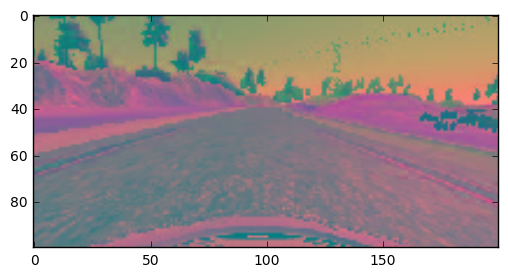

(100, 200, 3)

In [12]:
# Printing how the upper part of the imaged is blackened in order to limit the 
# details for the neural network to the road, not the scenery
% matplotlib inline
import matplotlib.pyplot as plt
#image = ndimage.imread(X_train_sc[0], mode="RGB") / 255.

image = Image.open(X_train_sc[0]) 
image = image.convert('YCbCr')
image = ImageOps.fit(image, size=(200, 100))
image = np.ndarray((image.size[1], image.size[0], 3), 'u1', image.tobytes())
#image = image[34:,:,:]

plt.imshow(image)
plt.show()
image.shape

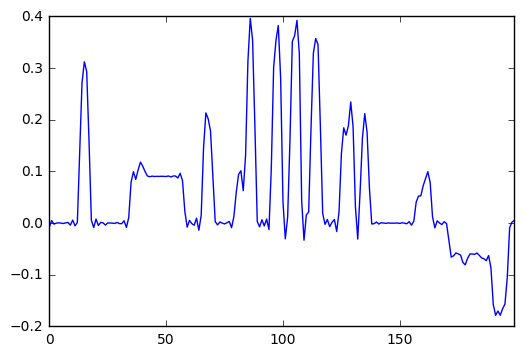

In [13]:
# Plotting the stearing angle of the training data (1500 points)
% matplotlib inline
draw = pd.Series(y_train[1000:1200]).plot()
plt.show()

In [14]:
# The training data is prepared in order for the neural network to learn
# to drive on the road
# First, the data is capped to 0.6 (no high steering angles)
X_sc = np.array(X_train_sc)
y_sc = np.array(y_train, float)
#y_sc = datagen.cap(np.array(y_train), 0.00, 0.80)

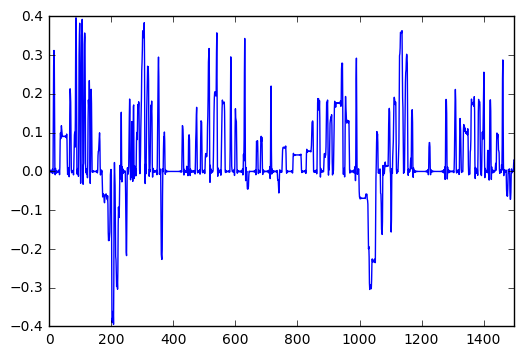

In [15]:
# Plotting the capped stearing angle of the training data (1500 points)
% matplotlib inline
draw = pd.Series(y_sc[1000:2500]).plot()
plt.show()

In [16]:
# In order to reinforce certain behaviours in the car (drive straight, recover from sides, turn right as lef)
# the cases are choosen on the basis of the type (ordinary or recovery), oversampling right angles and steering
# in general and undersampling straight driving
#reinforce_correction = [n for n,(x,y) in enumerate(zip(X_sc, y_sc)) if 'recovery' in x and np.abs(y)>0.05]
#reinforce_steering   = [n for n,(x,y) in enumerate(zip(X_sc, y_sc)) if np.abs(y)>0.05]
#reinforce_right_steering  = [n for n,(x,y) in enumerate(zip(X_sc, y_sc)) if y>0.05]
#reinforce_straight_steering  = [m for p,m in enumerate([n for n,(x,y) in enumerate(zip(X_sc, y_sc)) if y==0]) if p%15==0]
#reinforce = np.array(reinforce_correction + reinforce_steering + reinforce_right_steering + reinforce_right_steering + reinforce_straight_steering)
#X_sc = X_sc[reinforce]
#y_sc = y_sc[reinforce]

In [17]:
# The training data distribution is printed, pointing out the mean stearing angle
print ("Steering distribution for training -> mean:%0.3f count:[%i|%i|%i]" % (np.mean(y_sc), np.sum(y_sc<0), np.sum(y_sc==0.0), np.sum(y_sc>0)))

Steering distribution for training -> mean:0.032 count:[13647|0|14760]


In [18]:
# The training data is shuffled in order to present the neural network with varied examples
# Moreover, since the optimization algorithm is SGD, it naturally expects randomly picked
# examples in order to work better
shuffle = True
selection = np.array(list(range(len(y_sc))))
if shuffle:
    np.random.shuffle(selection) 
X_train = list(X_sc[selection])
y_train = y_sc[selection]

examples = len(y_train)

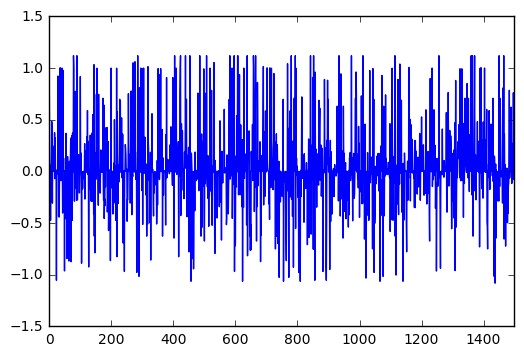

In [19]:
# The newly generated distribution of steering angles is now presented
% matplotlib inline
draw = pd.Series(y_train[1000:2500]).plot()
plt.show()

In [20]:
# The number of epoch is set high because we will use an early stop method
nb_epoch = 3

# This batch size is suitable for running on my GPU (larger batches will cause out-of-memory)
batch = 32

# Here we can decide if to use the mirroring of images (in order to increase their number 
# and balance the number of angle directions) and masking the upper part of the image
mirror = True
mask   = True
if mirror:
    samples = examples*2
else:
    samples = examples

# Early stopping is set on validation loss, with a patience of 3 epochs
callbacks = [EarlyStopping(monitor='val_driving_acc', patience=0, verbose=1)]

# The model is fit using the generator
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch, mirror=mirror, upper_mask=mask),
                    samples_per_epoch=samples, 
                    nb_epoch=nb_epoch, verbose=1,
                    validation_data=datagen.flow(X_valid_sc, y_valid, batch_size=batch, upper_mask=mask),
                    nb_val_samples=len(X_valid_sc),
                    callbacks=callbacks)

Epoch 1/3
56814/56814 [==============================] - 366s - loss: 0.1522 - driving_acc: 10.0679 - val_loss: 0.0694 - val_driving_acc: 46.0584
Epoch 2/3
56814/56814 [==============================] - 562s - loss: 0.1402 - driving_acc: 9.6314 - val_loss: 0.0701 - val_driving_acc: 15.3668
Epoch 00001: early stopping


(1, 2)

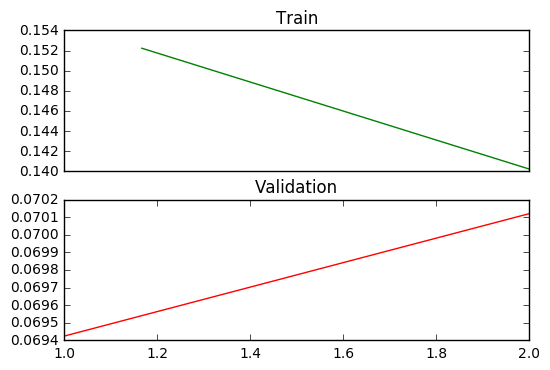

In [21]:
# The learnig is visualized. The final epoch is the 10th 
batches = range(1,len(history.history['loss'])+1)
loss_plot = plt.subplot(211)
loss_plot.set_title('Train')
loss_plot.plot(batches, history.history['loss'], 'g')
loss_plot.axes.get_xaxis().set_ticks([])
acc_plot = plt.subplot(212)
acc_plot.set_title('Validation')
acc_plot.plot(batches, history.history['val_loss'], 'r')
acc_plot.set_xlim([batches[0], batches[-1]])

In [22]:
# Now that the neural network is built, I test it on the train, validation and test data in order to
# highlight what is working and what is not (is it good predicting steering left or right? What about going straight?)

# The test is done on track 2, therefore this is a test of generalization (it actually cannot run on track 2...)

from sklearn.metrics import mean_squared_error
check_schedule =[('TRAIN', train_schedule),('VALIDATION', validation_schedule),('TEST', test_schedule)]

for label, a_schedule in check_schedule:
    print ('\n'+label+'\n'+'-'*len(label))
    for j in range(len(a_schedule)):
        X_train_sc, y_train = schedule([a_schedule[j]])
        error = 0.0
        y_true, y_pred = list(),list()
        for n,(img, response) in enumerate(zip(X_train_sc, y_train)):
            
            image = Image.open(img) 
            image = image.convert('YCbCr')
            image = ImageOps.fit(image, size=(200, 100))
            image = np.ndarray((image.size[1], image.size[0], 3), 'u1', image.tobytes())
            #image = image[34:,:,:]
            image = image/ 255.
            
            transformed_image_array = image[None, :, :, :]
            steering_angle = float(model.predict(transformed_image_array, batch_size=1))
            error += (response - steering_angle)**2
            MSE = (error / float(n+1))
            y_true.append(response)
            y_pred.append(steering_angle)
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        MSE_straight = mean_squared_error(y_true=y_true[y_true == 0.0], y_pred=y_pred[y_true==0])
        MSE_right = mean_squared_error(y_true=y_true[y_true > 0.0], y_pred=y_pred[y_true > 0])
        MSE_left = mean_squared_error(y_true=y_true[y_true < 0.0], y_pred=y_pred[y_true < 0])

        print ("%s (mean=%0.3f, strength:%0.3f, var:%0.3f): MSE_tot:%0.3f MSE_lsr:[%0.3f|%0.3f|%0.3f]" % (a_schedule[j], np.mean(y_true), 
                                                                                                  np.mean(np.abs(y_true)>0.5), np.var(y_true), 
                                                                                                  MSE, MSE_left,MSE_straight, MSE_right))


TRAIN
-----
chen01.csv (mean=0.005, strength:0.006, var:0.017): MSE_tot:0.015 MSE_lsr:[0.024|0.002|0.036]
chen02.csv (mean=0.023, strength:0.134, var:0.120): MSE_tot:0.120 MSE_lsr:[0.123|0.003|0.230]

VALIDATION
----------
track_b_fb.csv (mean=0.013, strength:0.102, var:0.082): MSE_tot:0.096 MSE_lsr:[0.140|0.020|0.199]
track_a_f.csv (mean=-0.041, strength:0.028, var:0.027): MSE_tot:0.026 MSE_lsr:[0.081|0.003|0.122]

TEST
----
track_a_b.csv (mean=0.039, strength:0.036, var:0.033): MSE_tot:0.034 MSE_lsr:[0.089|0.002|0.119]


In [23]:
# The model's network architecture is saved to disk
json_string = model.to_json()
with open('model.json', 'w') as json_file:
    json.dump(json_string, json_file)

In [24]:
# The model's weights are saved to disk
model.save_weights('model.h5')